In [28]:
import os
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt



In [29]:
# ==================================================
# Data Augmentation Offline para Imágenes NOK
# ==================================================
def save_augmented_images_and_masks(image, mask, folder, base_name, augment_index):
    """
    Guarda imágenes y máscaras aumentadas en el directorio correspondiente.
    """
    augmented_image_name = f"{base_name}_aug_{augment_index}.jpg"
    augmented_mask_name = f"{base_name}_aug_{augment_index}_label.bmp"

    # Guardar imagen aumentada
    image.save(os.path.join(folder, augmented_image_name))
    
    # Guardar máscara aumentada
    mask.save(os.path.join(folder, augmented_mask_name))


def augment_nok_images(root_dir, num_augmentations=3):
    """
    Realiza data augmentation exclusivamente para imágenes `NOK` y guarda las nuevas imágenes y máscaras.
    """
    augmentation_transforms = [
        # transforms.RandomRotation(15),  # Rotación aleatoria de -15 a 15 grados
        transforms.RandomHorizontalFlip(p=1),  # Flip horizontal
        transforms.RandomVerticalFlip(p=1),  # Flip vertical
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Cambios en brillo y contraste
    ]

    for folder in sorted(os.listdir(root_dir)):
        folder_path = os.path.join(root_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        # Leer imágenes y máscaras
        images = sorted([f for f in os.listdir(folder_path) if f.endswith(".jpg")])
        masks = sorted([f for f in os.listdir(folder_path) if f.endswith("_label.bmp")])

        # Asegurarse de que cada imagen tiene su máscara correspondiente
        for img_name, mask_name in zip(images, masks):
            img_path = os.path.join(folder_path, img_name)
            mask_path = os.path.join(folder_path, mask_name)

            # Cargar imagen y máscara
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")

            # Verificar si es `NOK` (máscara con valores mayores a 0)
            mask_tensor = torch.tensor(list(mask.getdata())).reshape(mask.size)
            if mask_tensor.max() > 0:  # Es una imagen `NOK`
                # Generar imágenes aumentadas
                for i in range(num_augmentations):
                    transform = random.choice(augmentation_transforms)  # Elegir transformación aleatoria
                    augmented_image = transform(image)  # Aplicar transformación a la imagen
                    augmented_mask = transform(mask)   # Aplicar transformación a la máscara

                    # Guardar las imágenes y máscaras aumentadas
                    base_name = os.path.splitext(img_name)[0]
                    save_augmented_images_and_masks(augmented_image, augmented_mask, folder_path, base_name, i)

    print("Data augmentation para imágenes NOK completado y guardado en las carpetas correspondientes.")


# ==================================================
# Dataset Personalizado
# ==================================================
class DefectDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment_NOK=False):
        self.root_dir = root_dir
        self.transform = transform
        self.augment_NOK = augment_NOK
        self.data = []
        self._load_data()
    
    def _load_data(self):
        for folder in sorted(os.listdir(self.root_dir)):
            folder_path = os.path.join(self.root_dir, folder)
            if not os.path.isdir(folder_path):
                continue
            
            images = sorted(glob.glob(os.path.join(folder_path, "Part*.jpg")))
            masks = sorted(glob.glob(os.path.join(folder_path, "Part*_label.bmp")))
            
            for img_path, mask_path in zip(images, masks):
                mask = Image.open(mask_path).convert("L")
                mask_array = torch.tensor(list(mask.getdata())).reshape(mask.size)
                label = 1 if mask_array.max() > 0 else 0
                self.data.append((img_path, label))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


# ==================================================
# Configuración de Transformaciones y Dataset
# ==================================================
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

root_dir = "Imagenes_defectos"

# Realizar data augmentation para imágenes NOK
augment_nok_images(root_dir, num_augmentations=5)

# Crear el dataset
dataset = DefectDataset(root_dir=root_dir, transform=transform)

# Dividir el dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# ==================================================
# Definición del Modelo
# ==================================================
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 64 * 64, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


# ==================================================
# Entrenamiento y Validación
# ==================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Entrenando"):
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Pérdida de entrenamiento: {train_loss:.4f}")
        validate_model(model, val_loader, criterion)


def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_loader)
    accuracy = 100 * correct / total
    print(f"Pérdida de validación: {val_loss:.4f}, Precisión: {accuracy:.2f}%")


train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


# ==================================================
# Evaluación
# ==================================================
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    print(f"Precisión en el conjunto de prueba: {accuracy:.2f}%")


test_model(model, test_loader)


Data augmentation para imágenes NOK completado y guardado en las carpetas correspondientes.


Epoch 1/10 - Entrenando: 100%|██████████| 29/29 [00:08<00:00,  3.62it/s]


Epoch 1/10, Pérdida de entrenamiento: 1.0770
Pérdida de validación: 0.6377, Precisión: 66.41%


Epoch 2/10 - Entrenando: 100%|██████████| 29/29 [00:06<00:00,  4.73it/s]


Epoch 2/10, Pérdida de entrenamiento: 0.5058
Pérdida de validación: 0.3533, Precisión: 87.79%


Epoch 3/10 - Entrenando: 100%|██████████| 29/29 [00:07<00:00,  4.10it/s]


Epoch 3/10, Pérdida de entrenamiento: 0.1959
Pérdida de validación: 0.2153, Precisión: 93.13%


Epoch 4/10 - Entrenando: 100%|██████████| 29/29 [00:07<00:00,  4.10it/s]


Epoch 4/10, Pérdida de entrenamiento: 0.0830
Pérdida de validación: 0.1553, Precisión: 92.37%


Epoch 5/10 - Entrenando: 100%|██████████| 29/29 [00:07<00:00,  4.06it/s]


Epoch 5/10, Pérdida de entrenamiento: 0.0242
Pérdida de validación: 0.1267, Precisión: 94.66%


Epoch 6/10 - Entrenando: 100%|██████████| 29/29 [00:07<00:00,  4.03it/s]


Epoch 6/10, Pérdida de entrenamiento: 0.0047
Pérdida de validación: 0.1162, Precisión: 96.18%


Epoch 7/10 - Entrenando: 100%|██████████| 29/29 [00:07<00:00,  4.12it/s]


Epoch 7/10, Pérdida de entrenamiento: 0.0022
Pérdida de validación: 0.1333, Precisión: 96.18%


Epoch 8/10 - Entrenando: 100%|██████████| 29/29 [00:07<00:00,  4.02it/s]


Epoch 8/10, Pérdida de entrenamiento: 0.0009
Pérdida de validación: 0.1446, Precisión: 96.18%


Epoch 9/10 - Entrenando: 100%|██████████| 29/29 [00:07<00:00,  4.05it/s]


Epoch 9/10, Pérdida de entrenamiento: 0.0006
Pérdida de validación: 0.1495, Precisión: 96.18%


Epoch 10/10 - Entrenando: 100%|██████████| 29/29 [00:07<00:00,  4.06it/s]


Epoch 10/10, Pérdida de entrenamiento: 0.0004
Pérdida de validación: 0.1475, Precisión: 96.18%
Precisión en el conjunto de prueba: 89.55%


In [32]:
print(len(dataset))

659


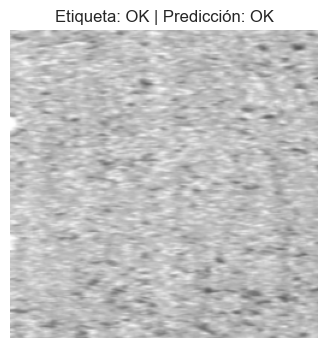

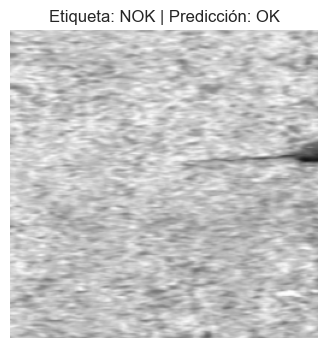

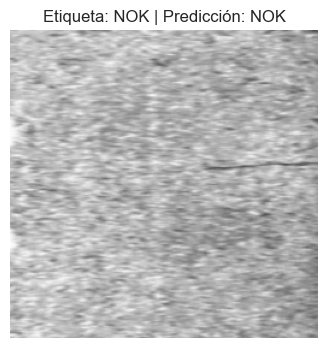

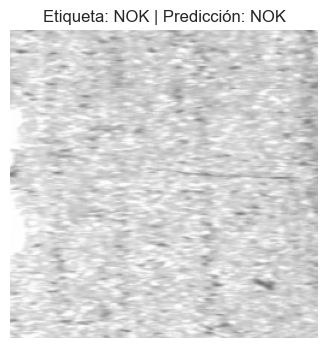

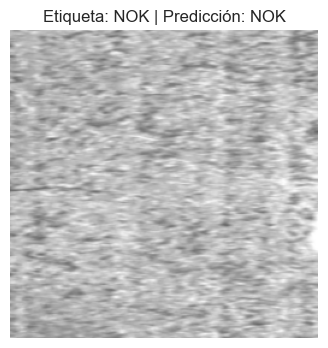

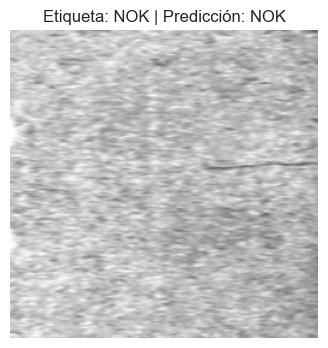

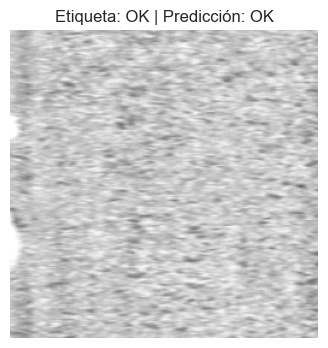

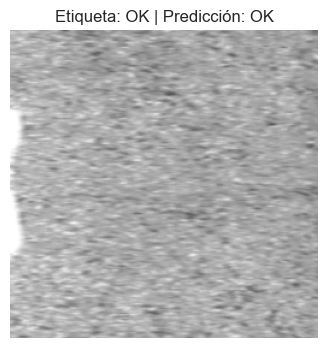

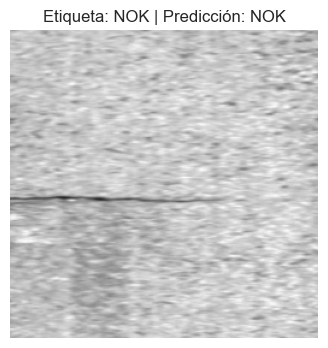

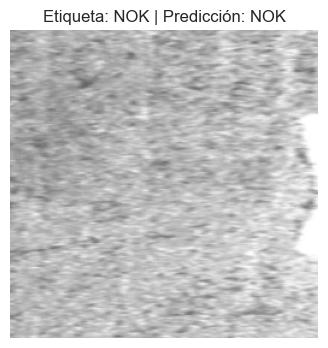


Resultados del Modelo:
Imágenes OK correctamente clasificadas: 28
Imágenes OK mal clasificadas: 5
Imágenes NOK correctamente clasificadas: 32
Imágenes NOK mal clasificadas: 2
Precisión total: 89.55%


In [34]:
# ==================================================
# Evaluación con Conteo de OK y NOK
# ==================================================
def evaluate_and_visualize(model, test_loader, num_visualizations=10):
    """
    Evalúa el modelo, cuenta las imágenes OK y NOK correctamente y mal clasificadas,
    y muestra ejemplos de imágenes con sus predicciones.
    """
    model.eval()
    ok_correct = 0
    ok_incorrect = 0
    nok_correct = 0
    nok_incorrect = 0
    total = 0
    images_visualized = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()  # Predicciones binarias
            
            # Conteo de OK y NOK correctamente e incorrectamente clasificadas
            for i in range(labels.size(0)):
                if labels[i].item() == 0:  # OK
                    if predictions[i].item() == 0:
                        ok_correct += 1
                    else:
                        ok_incorrect += 1
                else:  # NOK
                    if predictions[i].item() == 1:
                        nok_correct += 1
                    else:
                        nok_incorrect += 1
                
                # Visualización de imágenes (hasta num_visualizations)
                if images_visualized < num_visualizations:
                    visualize_image(images[i], labels[i].item(), predictions[i].item())
                    images_visualized += 1
            
            total += labels.size(0)

    # Imprimir resultados
    print("\nResultados del Modelo:")
    print(f"Imágenes OK correctamente clasificadas: {ok_correct}")
    print(f"Imágenes OK mal clasificadas: {ok_incorrect}")
    print(f"Imágenes NOK correctamente clasificadas: {nok_correct}")
    print(f"Imágenes NOK mal clasificadas: {nok_incorrect}")
    print(f"Precisión total: {(ok_correct + nok_correct) / total * 100:.2f}%")

# ==================================================
# Visualización de Imágenes
# ==================================================
def visualize_image(image, label, prediction):
    """
    Muestra una imagen con su etiqueta real y predicción.
    """
    image = image.cpu().permute(1, 2, 0)  # Convertir a formato HWC para matplotlib
    image = image * 0.5 + 0.5  # Revertir la normalización (mean=0.5, std=0.5)

    plt.figure(figsize=(4, 4))
    plt.imshow(image.numpy())
    plt.title(f"Etiqueta: {'OK' if label == 0 else 'NOK'} | Predicción: {'OK' if prediction == 0 else 'NOK'}")
    plt.axis('off')
    plt.show()


# ==================================================
# Evaluar y Visualizar
# ==================================================
evaluate_and_visualize(model, test_loader, num_visualizations=10)


In [35]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def evaluate_with_confusion_matrix(model, test_loader):
    """
    Evalúa el modelo y genera una matriz de confusión.
    """
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()

            # Guardar etiquetas reales y predicciones
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Calcular matriz de confusión
    cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1])  # Etiquetas: 0 = OK, 1 = NOK
    plot_confusion_matrix(cm, classes=['OK', 'NOK'])


def plot_confusion_matrix(cm, classes):
    """
    Muestra una matriz de confusión como un gráfico.
    """
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')
    plt.title('Matriz de Confusión')
    plt.show()

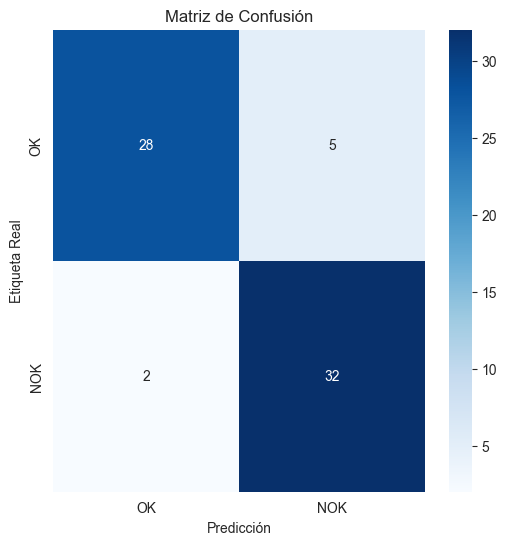

In [36]:
evaluate_with_confusion_matrix(model, test_loader)

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

def calculate_f1_score(model, test_loader):
    """
    Calcula el F1-score, precisión y recall del modelo usando el conjunto de prueba.
    """
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()

            # Guardar etiquetas reales y predicciones
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Calcular matriz de confusión
    cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1])
    print("Matriz de Confusión:")
    print(cm)

    # Generar reporte de métricas
    report = classification_report(all_labels, all_predictions, target_names=["OK", "NOK"])
    print("\nReporte de Clasificación:")
    print(report)


In [38]:
def find_and_analyze_misclassified(model, test_loader, num_visualizations=10):
    """
    Encuentra las imágenes mal clasificadas, las visualiza y analiza posibles razones.
    """
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()

            # Identificar las imágenes mal clasificadas
            for i in range(labels.size(0)):
                if predictions[i].item() != labels[i].item():
                    misclassified.append((images[i], labels[i].item(), predictions[i].item()))

    # Visualizar las imágenes mal clasificadas
    visualize_misclassified(misclassified, num_visualizations)


def visualize_misclassified(misclassified, num_visualizations):
    """
    Visualiza imágenes mal clasificadas con etiquetas reales y predicciones.
    """
    for i, (image, label, prediction) in enumerate(misclassified[:num_visualizations]):
        image = image.cpu().permute(1, 2, 0)  # Convertir a formato HWC para matplotlib
        image = image * 0.5 + 0.5  # Revertir la normalización (mean=0.5, std=0.5)

        plt.figure(figsize=(4, 4))
        plt.imshow(image.numpy())
        plt.title(f"Etiqueta: {'OK' if label == 0 else 'NOK'} | Predicción: {'OK' if prediction == 0 else 'NOK'}")
        plt.axis('off')
        plt.show()


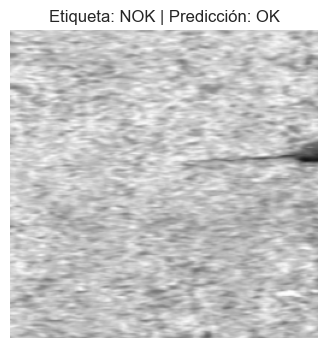

Análisis posible: La imagen tiene características ambiguas o ruido que puede haber confundido al modelo.


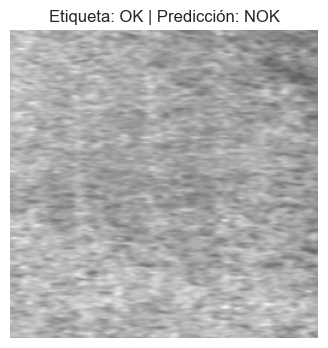

Análisis posible: La imagen tiene características ambiguas o ruido que puede haber confundido al modelo.


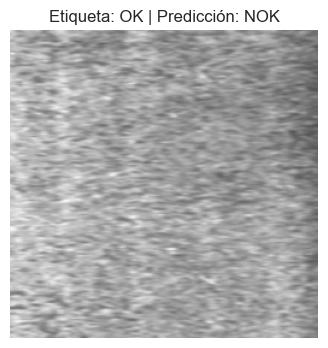

Análisis posible: La imagen tiene características ambiguas o ruido que puede haber confundido al modelo.


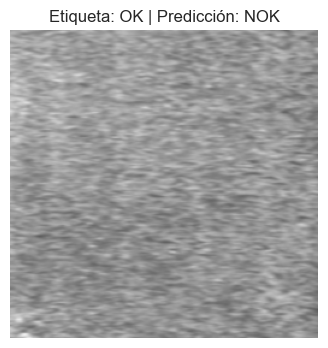

Análisis posible: La imagen tiene características ambiguas o ruido que puede haber confundido al modelo.


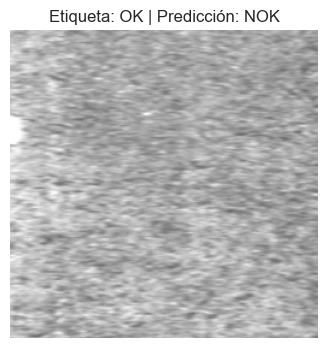

Análisis posible: La imagen tiene características ambiguas o ruido que puede haber confundido al modelo.


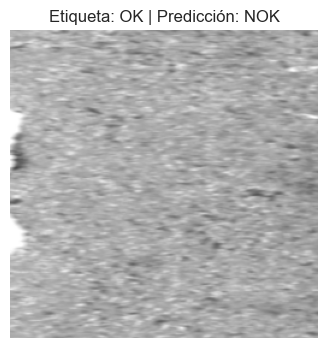

Análisis posible: La imagen tiene características ambiguas o ruido que puede haber confundido al modelo.


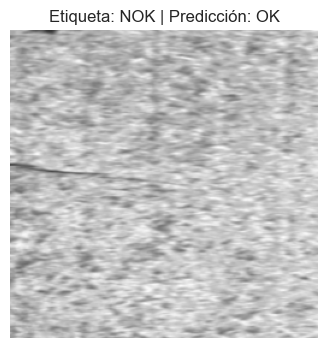

Análisis posible: La imagen tiene características ambiguas o ruido que puede haber confundido al modelo.


In [39]:
find_and_analyze_misclassified(model, test_loader, num_visualizations=10)


In [40]:
calculate_f1_score(model, test_loader)


Matriz de Confusión:
[[28  5]
 [ 2 32]]

Reporte de Clasificación:
              precision    recall  f1-score   support

          OK       0.93      0.85      0.89        33
         NOK       0.86      0.94      0.90        34

    accuracy                           0.90        67
   macro avg       0.90      0.89      0.90        67
weighted avg       0.90      0.90      0.90        67



In [41]:
# ==================================================
# Guardar el modelo entrenado
# ==================================================
def save_model(model, optimizer, path="modelo.pkl"):
    """
    Guarda el modelo y el optimizador en un archivo .pkl.
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, path)
    print(f"Modelo guardado en {path}")


In [42]:
save_model(model, optimizer, path="simple_cnn_model.pkl")

Modelo guardado en simple_cnn_model.pkl
